<a href="https://colab.research.google.com/github/Indhusaikar/My-QC/blob/main/COVID_19_Lung_CT_Scans_co_500_nonco_150_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install pennylane
from IPython.display import clear_output
clear_output()

In [12]:


import pennylane as qml
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from keras.datasets import cifar10, fashion_mnist, mnist
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from sklearn.preprocessing import OneHotEncoder
import math
import threading


device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


In [2]:
# Standard Libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set dataset path
DATASET_PATH = "/content/drive/MyDrive/COVID-19_Lung_CT_Scans  co_500 nonco_150"
COVID_PATH = os.path.join(DATASET_PATH, "/content/drive/MyDrive/COVID-19_Lung_CT_Scans  co_500 nonco_150/COVID-19")
NONCOVID_PATH = os.path.join(DATASET_PATH, "/content/drive/MyDrive/COVID-19_Lung_CT_Scans  co_500 nonco_150/Non-COVID-19")


In [3]:
def load_images_from_folder(folder_path, label, img_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)
    return images, labels

# Load COVID and Non-COVID images
covid_images, covid_labels = load_images_from_folder(COVID_PATH, 1)
noncovid_images, noncovid_labels = load_images_from_folder(NONCOVID_PATH, 0)

# Combine and convert to numpy arrays
X = np.array(covid_images + noncovid_images)
y = np.array(covid_labels + noncovid_labels)

# Expand dimensions for CNN
X = X.reshape(-1, 128, 128, 1) / 255.0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:


# Resize images to 16x16 for Amplitude Embedding (256 features for 8 qubits)
# Assuming X_train and X_test are already loaded and preprocessed as numpy arrays
X_train_resized = X_train.reshape(-1, 128, 128) # Remove the channel dimension for resizing
X_test_resized = X_test.reshape(-1, 128, 128)

# Use cv2.resize for resizing
X_train_resized = np.array([cv2.resize(img, (16, 16)) for img in X_train_resized])
X_test_resized = np.array([cv2.resize(img, (16, 16)) for img in X_test_resized])

# Flatten the resized images to a 1D vector of size 256
X_train_flat = X_train_resized.reshape(-1, 16*16)
X_test_flat = X_test_resized.reshape(-1, 16*16)

print(f"Resized and flattened training data shape: {X_train_flat.shape}")
print(f"Resized and flattened testing data shape: {X_test_flat.shape}")


Resized and flattened training data shape: (526, 256)
Resized and flattened testing data shape: (132, 256)


In [18]:
import pennylane as qml
import numpy as np

# Set up the device with 10 qubits (8 for features, 2 for ancilla)
dev = qml.device("default.qubit", wires=10)

# Define the quantum circuit
@qml.qnode(dev, interface='autograd') # Using autograd interface for numpy arrays
def quantum_circuit(features, phis):
    # Amplitude encoding with equal amplitudes for all 256 states (2^8 = 256)
    qml.AmplitudeEmbedding(features=features, wires=range(8), normalize=True)

    # First Convolution
    qml.CRY(phi=phis[0], wires=[7, 6])
    qml.CRY(phi=phis[1], wires=[6, 5])
    qml.CRY(phi=phis[2], wires=[5, 4])
    qml.CRY(phi=phis[3], wires=[4, 7])
    qml.CRY(phi=phis[4], wires=[3, 2])
    qml.CRY(phi=phis[5], wires=[2, 1])
    qml.CRY(phi=phis[6], wires=[1, 0])
    qml.CRY(phi=phis[7], wires=[0, 3])
    qml.Barrier()

    # First Pooling
    qml.CRZ(phi=phis[8], wires=[7, 6])
    qml.X(wires=7)
    qml.CRX(phi=phis[9], wires=[7, 6])
    qml.CRZ(phi=phis[3], wires=[3, 2]) # Corrected index to 3 from 8
    qml.X(wires=3)
    qml.CRX(phi=phis[9], wires=[3, 2])
    qml.Barrier()

    # Activations 1
    qml.Hadamard(wires=0)
    qml.RZ(phi=phis[10], wires=0)
    qml.Hadamard(wires=1)
    qml.RZ(phi=phis[11], wires=1)
    qml.Hadamard(wires=2)
    qml.RZ(phi=phis[12], wires=2)
    qml.Hadamard(wires=4)
    qml.RZ(phi=phis[13], wires=4)
    qml.Hadamard(wires=5)
    qml.RZ(phi=phis[14], wires=5)
    qml.Hadamard(wires=6)
    qml.RZ(phi=phis[15], wires=6)
    qml.Barrier()

    # Second Convolution
    qml.CRY(phi=phis[16], wires=[6, 5])
    qml.CRY(phi=phis[17], wires=[5, 4])
    qml.CRY(phi=phis[18], wires=[4, 6])
    qml.CRY(phi=phis[19], wires=[2, 1])
    qml.CRY(phi=phis[20], wires=[1, 0])
    qml.CRY(phi=phis[21], wires=[0, 2])
    qml.Barrier()

    # Second Pooling
    qml.CRZ(phi=phis[22], wires=[6, 5])
    qml.X(wires=6)
    qml.CRX(phi=phis[23], wires=[6, 5])
    qml.CRZ(phi=phis[19], wires=[2, 1]) # Corrected index to 19 from 22
    qml.X(wires=2)
    qml.CRX(phi=phis[23], wires=[2, 1])
    qml.Barrier()

    # Activations 2
    qml.Hadamard(wires=0)
    qml.RZ(phi=phis[24], wires=0)
    qml.Hadamard(wires=1)
    qml.RZ(phi=phis[25], wires=1)
    qml.Hadamard(wires=4)
    qml.RZ(phi=phis[26], wires=4)
    qml.Hadamard(wires=5)
    qml.RZ(phi=phis[27], wires=5)
    qml.Barrier()

    # Third Convolution
    qml.CRY(phi=phis[28], wires=[5, 4])
    qml.CRY(phi=phis[29], wires=[4, 5])
    qml.CRY(phi=phis[30], wires=[1, 0])
    qml.CRY(phi=phis[31], wires=[0, 1])
    qml.Barrier()

    # Third Pooling
    qml.CRZ(phi=phis[32], wires=[5, 4])
    qml.X(wires=5)
    qml.CRX(phi=phis[33], wires=[5, 4])
    qml.CRZ(phi=phis[30], wires=[1, 0]) # Corrected index to 30 from 32
    qml.X(wires=1)
    qml.CRX(phi=phis[33], wires=[1, 0])

    # Ancilla qubits (used for measurement, not for the final expectation value)
    # Removed CNOT gates to ancilla qubits as we are now measuring a single qubit

    # Return the expectation value of a single qubit (e.g., qubit 8)
    return qml.expval(qml.PauliZ(8)) # Measure the expectation value of PauliZ on qubit 8

In [8]:

for i in results:
    print(i**(1/2))

[0.54209536 0.59408451 0.410596   0.42965933]
[0.53748031 0.36273278 0.61659789 0.4464828 ]
[0.27226435 0.38329282 0.54829113 0.69161808]
[0.63583272 0.45742698 0.49889319 0.37092169]
[0.45718723 0.49315681 0.49598812 0.54933776]
[0.40353405 0.6200022  0.38655522 0.55075639]
[0.55003815 0.68578999 0.30879436 0.36303742]
[0.54743779 0.49204239 0.50582906 0.44982565]
[0.56960714 0.45808777 0.51516909 0.44755346]
[0.42977944 0.34697732 0.66997958 0.4960078 ]
[0.31412299 0.52157551 0.42137125 0.67211011]
[0.41995551 0.26280762 0.72308517 0.48137029]
[0.28692623 0.56771975 0.4197101  0.6474651 ]
[0.5390825  0.43197562 0.55897255 0.45862492]
[0.4098836  0.55882944 0.44828119 0.56457866]
[0.59861602 0.45029165 0.52315861 0.4064497 ]
[0.42498506 0.33368899 0.6789366  0.4970759 ]
[0.439665   0.45526946 0.54436882 0.55053338]
[0.52862727 0.51146639 0.45784237 0.49933527]
[0.41581881 0.35648635 0.60844989 0.57428298]
[0.36604934 0.34532306 0.6409007  0.57966038]
[0.46819031 0.28479519 0.69444107 

(<Figure size 3500x1100 with 1 Axes>, <Axes: >)


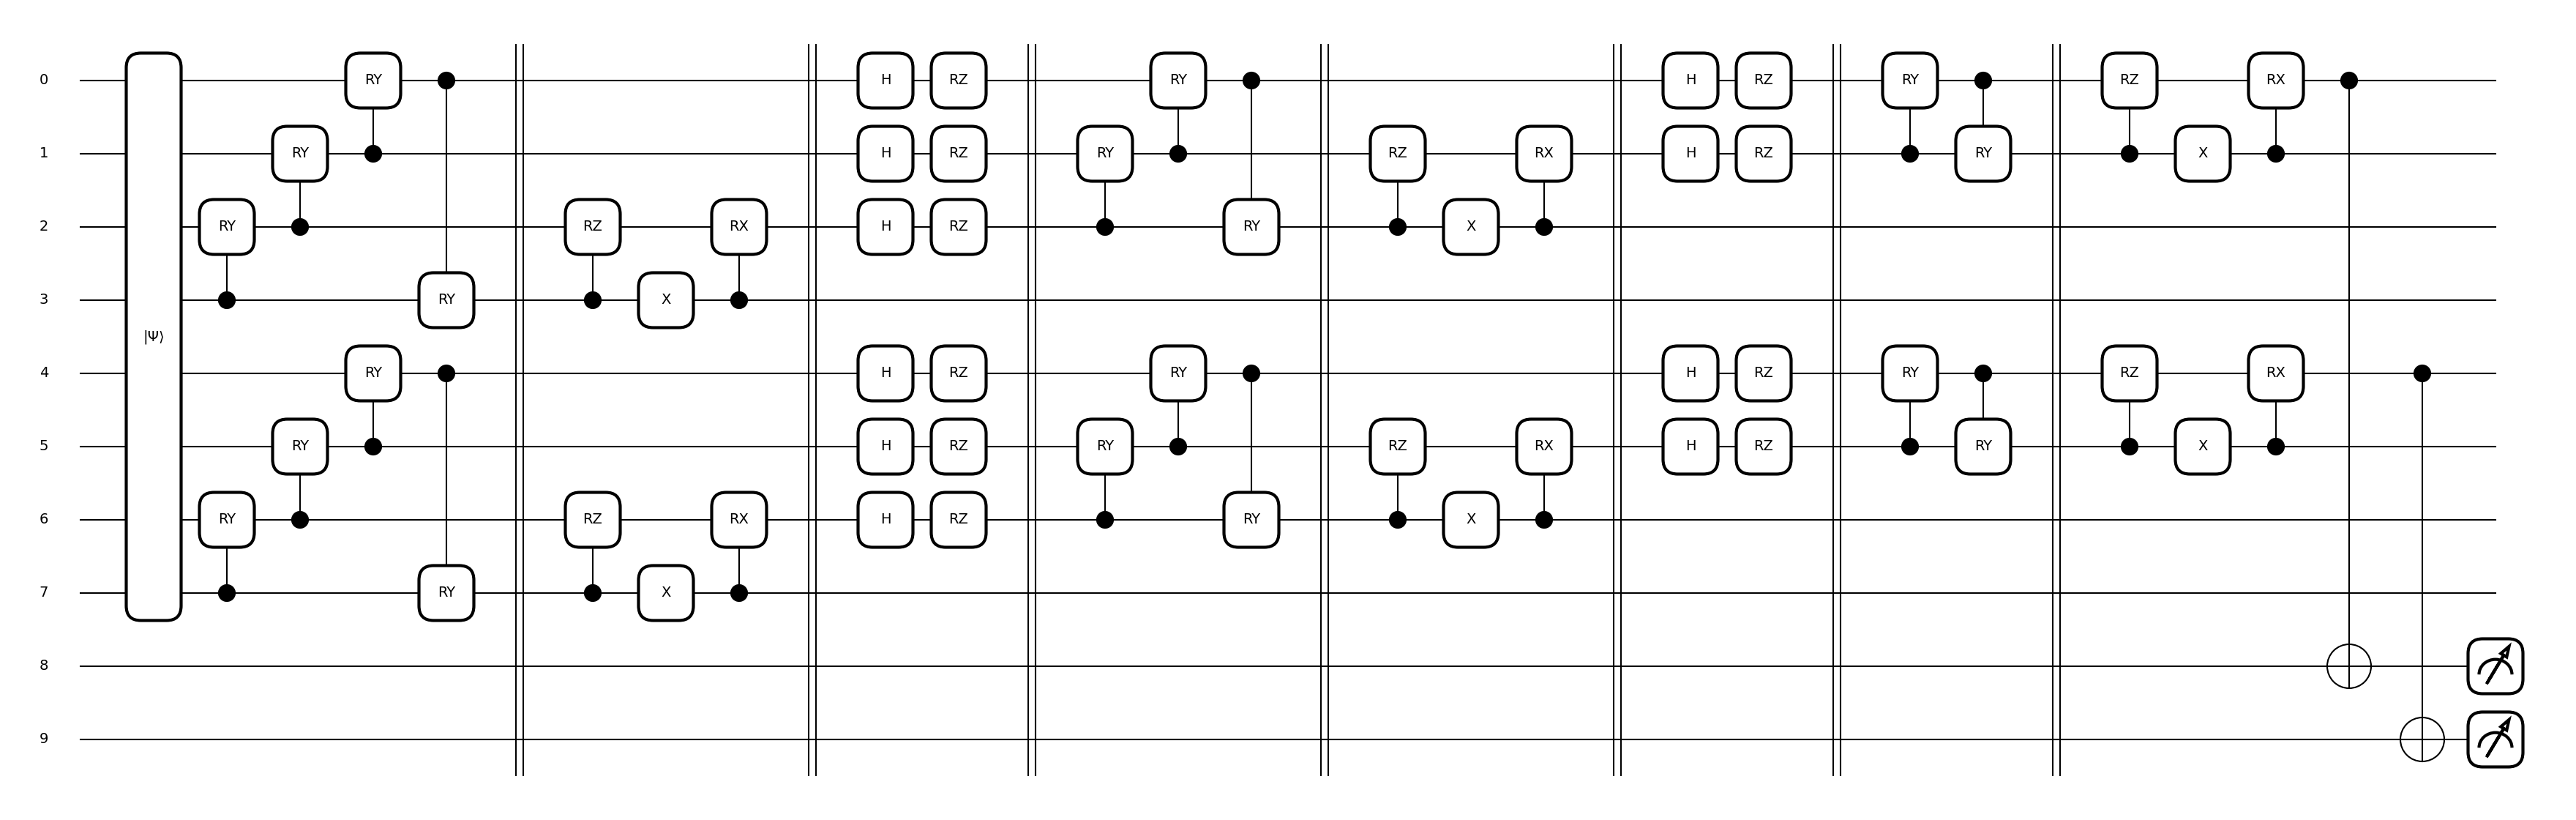

In [9]:

drawer = qml.draw_mpl(quantum_circuit)(X_train_flat[0], phis)
print(drawer)


In [13]:
class QCNN(torch.nn.Module):
    def __init__(self):
        super(QCNN, self).__init__()
        # Initialize the trainable quantum circuit parameters with uniform distribution
        torch.random.manual_seed(42)
        self.phis = torch.nn.Parameter(torch.empty(34))
        torch.nn.init.uniform_(self.phis, a=-0.314, b=0.314)

    def forward(self, x):
        # Call the quantum circuit and return the expectation value
        constrained_phis = self.phis * np.pi
        # The quantum circuit now returns a single expectation value
        expectation_value = quantum_circuit(x, constrained_phis)
        # Return the raw expectation value for BCEWithLogitsLoss
        return expectation_value

In [14]:
# Set up the model, optimizer, and loss function
model = QCNN()
optimizer = Adam(model.parameters(), lr=0.001)
# Use BCEWithLogitsLoss for binary classification
loss_fn = torch.nn.BCEWithLogitsLoss()


In [15]:

def compute_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / len(labels)
    return accuracy

In [19]:
import torch
from torch.optim import Adam
from sklearn.model_selection import train_test_split

# Convert prepared data to PyTorch tensors
# Use the flattened training and testing data (X_train_flat, X_test_flat)
# and the original labels (y_train, y_test)

# Split the training data into training and validation sets
# Using 80% for training and 20% for validation from the original training set
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    X_train_flat, y_train, test_size=0.2, random_state=42
)

X_test_tensor = torch.tensor(X_test_flat, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32) # Changed dtype to float32 for BCELoss

# Convert the split data to tensors
X_train_tensor = torch.tensor(X_train_tensor, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.float32) # Changed dtype to float32 for BCELoss
X_val_tensor = torch.tensor(X_val_tensor, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_tensor, dtype=torch.float32) # Changed dtype to float32 for BCELoss


phi_history = []
loss_history = []
val_loss_history = []
accuracy_history = [0.0]
val_accuracy_history = [0.0]


# Early Stopping params
patience = 10
best_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)

# Training loop
num_epochs = 100  # Adjust as needed
batch_size = 32

for epoch in range(num_epochs):

    if early_stop:
        print("Early stopping triggered.")
        break

    epoch_loss = 0
    model.train()

    # Keep a record of parameter (phi) values
    phi_history.append(model.phis.clone().detach().numpy())

    # Shuffle the training data at the start of each epoch
    torch.manual_seed(seed + epoch)
    permutation = torch.randperm(X_train_tensor.size()[0])
    X_train_tensor = X_train_tensor[permutation]
    y_train_tensor = y_train_tensor[permutation]

    # Iterate over batches
    for i in range(0, len(X_train_tensor), batch_size):
        x_batch = X_train_tensor[i:i + batch_size]
        y_batch = y_train_tensor[i:i + batch_size].to(device) # Move y_batch to device

        optimizer.zero_grad()

        # Forward pass: compute predictions
        outputs = model(x_batch.to(device)).squeeze() # Move x_batch to device and squeeze

        # Compute cross-entropy loss
        loss = loss_fn(outputs, y_batch)

        # Backward pass: compute gradients and update weights
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Compute accuracy on the training set
    model.eval()
    with torch.no_grad():
        train_outputs = model(X_train_tensor.to(device)).squeeze() # Move to device
        # For binary classification, accuracy is calculated differently
        predicted_classes = (torch.sigmoid(train_outputs) > 0.5).float() # Apply sigmoid for prediction
        train_accuracy = (predicted_classes == y_train_tensor.to(device)).sum().item() / len(y_train_tensor) # Move to device
        accuracy_history.append(train_accuracy)
        loss_history.append(loss.item()) # Store the scalar loss value

    #print(f"Training Accuracy: {train_accuracy:.4f}")

    # Validation loss (on validation data)
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor.to(device)).squeeze() # Move to device
        val_loss = loss_fn(val_outputs, y_val_tensor.to(device)).item() # Move to device
        # For binary classification, accuracy is calculated differently
        predicted_classes = (torch.sigmoid(val_outputs) > 0.5).float() # Apply sigmoid for prediction
        val_accuracy = (predicted_classes == y_val_tensor.to(device)).sum().item() / len(y_val_tensor) # Move to device
        val_accuracy_history.append(val_accuracy)
        val_loss_history.append(val_loss)

    # Print epoch metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / (len(X_train_tensor) / batch_size):.4f}, Accuracy: {train_accuracy:.4f}  -  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Check for early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        early_stop = True

    if epochs_no_improve > 0:
        print(f"Epochs without improvement: {epochs_no_improve}")
    else:
        print("\n")

print("Training finished.")

/usr/local/lib/python3.11/dist-packages/pennylane/math/interface_utils.py:136: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Epoch 1/100, Loss: 0.5722, Accuracy: 0.7619  -  Validation Loss: 0.4736, Validation Accuracy: 0.8396


Epoch 2/100, Loss: 0.5722, Accuracy: 0.7619  -  Validation Loss: 0.4736, Validation Accuracy: 0.8396
Epochs without improvement: 1
Epoch 3/100, Loss: 0.5722, Accuracy: 0.7619  -  Validation Loss: 0.4736, Validation Accuracy: 0.8396
Epochs without improvement: 2
Epoch 4/100, Loss: 0.5722, Accuracy: 0.7619  -  Validation Loss: 0.4736, Validation Accuracy: 0.8396
Epochs without improvement: 3
Epoch 5/100, Loss: 0.5722, Accuracy: 0.7619  -  Validation Loss: 0.4736, Validation Accuracy: 0.8396


Epoch 6/100, Loss: 0.5722, Accuracy: 0.7619  -  Validation Loss: 0.4736, Validation Accuracy: 0.8396
Epochs without improvement: 1
Epoch 7/100, Loss: 0.5722, Accuracy: 0.7619  -  Validation Loss: 0.4736, Validation Accuracy: 0.8396
Epochs without improvement: 2
Epoch 8/100, Loss: 0.5722, Accuracy: 0.7619  -  Validation Loss: 0.4736, Validation Accuracy: 0.8396
Epochs without improvement: 3
Epoch 9/

In [20]:
from collections import defaultdict

# Initialize a dictionary to store counts per class
class_correct = defaultdict(int)
class_total = defaultdict(int)

test_outs = None
model.eval()

# List of class labels
class_labels = [0, 1]

with torch.no_grad():
    test_outputs = model(X_test_tensor.to(device)).squeeze() # Move to device and squeeze
    test_outs = test_outputs
    # For binary classification, predict based on the logit being > 0
    predicted = (test_outputs > 0).float().cpu() # Compare logits to 0, cast to float, and move to CPU

    # Calculate overall accuracy
    accuracy = (predicted == y_test_tensor.cpu()).sum().item() / len(y_test_tensor) # Move y_test_tensor to CPU for comparison
    print(f"Overall Test Accuracy: {accuracy:.4f}")

    # Calculate accuracy per class
    for i in range(len(y_test_tensor)):
        label = y_test_tensor[i].item()
        pred = predicted[i].item()

        if label == pred:
            class_correct[label] += 1
        class_total[label] += 1

# Print accuracy for each class
for label in class_labels:
    if class_total[label] > 0:
        class_accuracy = class_correct[label] / class_total[label]
        print(f"Accuracy for class {label}: {class_accuracy:.4f}")
    else:
        print(f"No samples found for class {label}.")


Overall Test Accuracy: 0.7500
Accuracy for class 0: 0.0000
Accuracy for class 1: 1.0000


In [21]:
# Evaluation on the test set
test_outs = None
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor.to(device)).squeeze() # Move to device and squeeze
    test_outs = test_outputs
    # For binary classification, predict based on the logit being > 0
    predicted = (test_outputs > 0).float().cpu() # Compare logits to 0, cast to float, and move to CPU

    # Calculate overall accuracy
    accuracy = (predicted == y_test_tensor.cpu()).sum().item() / len(y_test_tensor) # Move y_test_tensor to CPU for comparison
    print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.7500


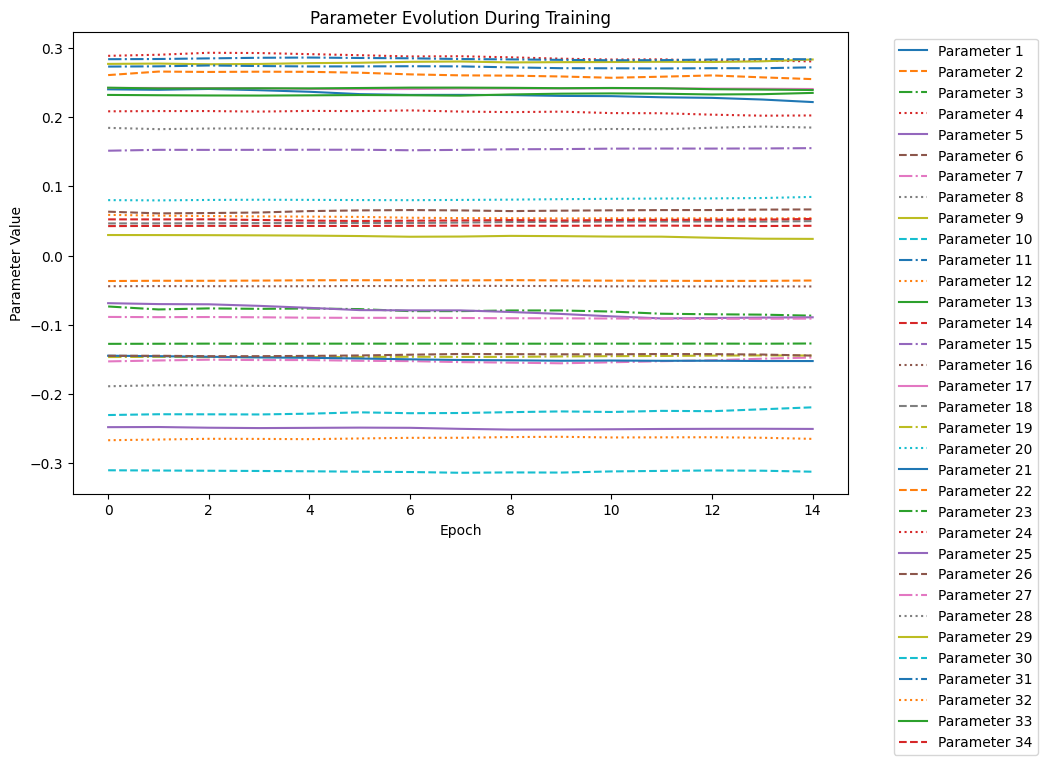

In [22]:
# Plot parameter history
parameter_history = np.array(phi_history)  # Convert to NumPy array for easier manipulation

# Defined line styes
line_styles = ['-', '--', '-.', ':']

plt.figure(figsize=(10, 6))
for i in range(len(model.phis)):  # 17 parameters
    plt.plot(parameter_history[:, i], label=f'Parameter {i+1}', linestyle=line_styles[i % len(line_styles)])

plt.title("Parameter Evolution During Training")
plt.xlabel("Epoch")
plt.ylabel("Parameter Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.tight_layout()
plt.show()



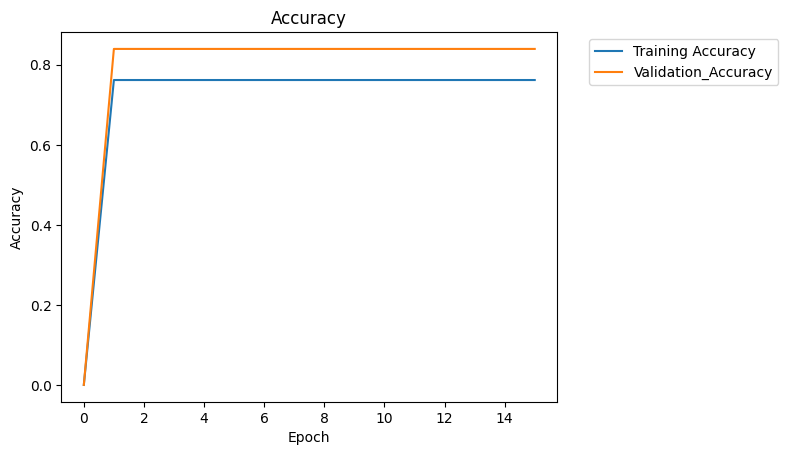

In [23]:

plt.plot(accuracy_history, label="Training Accuracy")
plt.plot(val_accuracy_history, label="Validation_Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()


In [24]:

print("Total samples:", X.shape[0])
print("Image shape:", X.shape[1:])  # (128, 128, 1)
print("X shape:", X.shape)
print("y shape:", y.shape)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Total samples: 658
Image shape: (128, 128, 1)
X shape: (658, 128, 128, 1)
y shape: (658,)
Training set size: 526
Test set size: 132


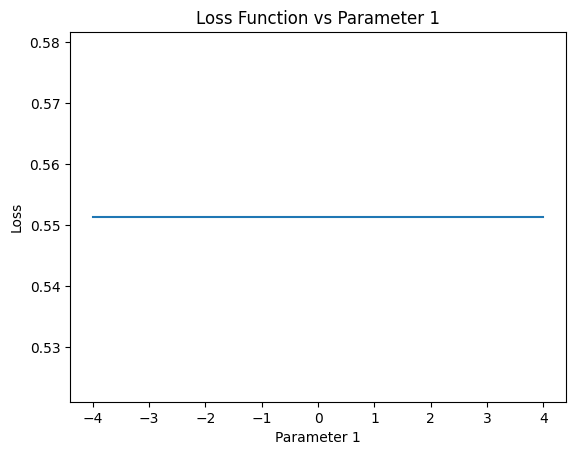

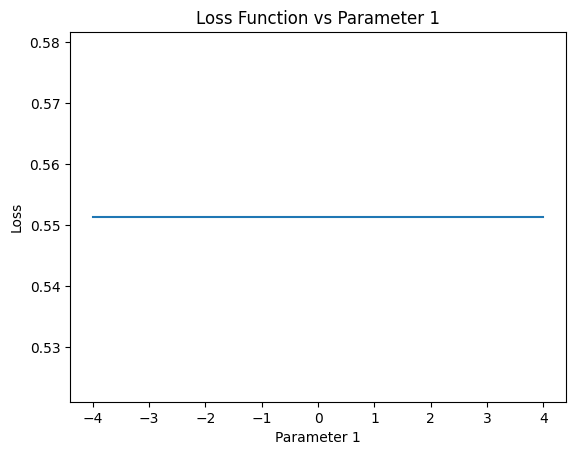

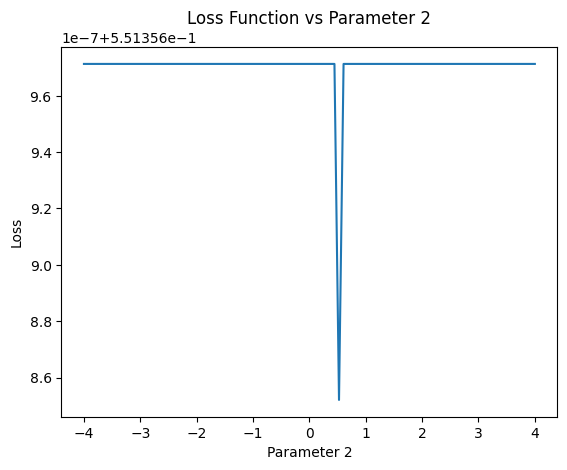

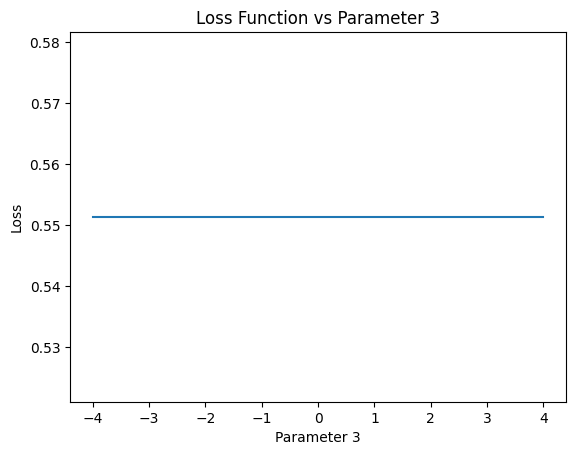

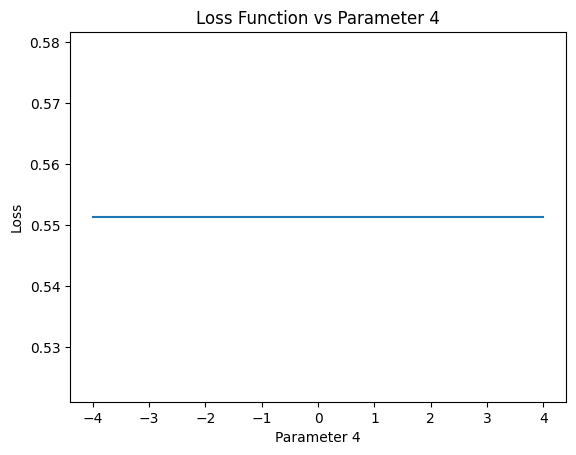

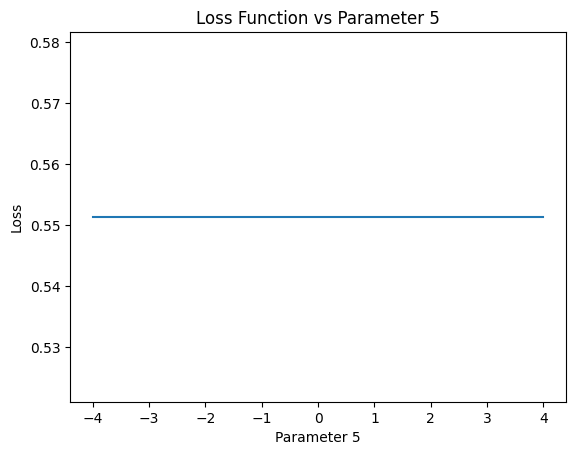

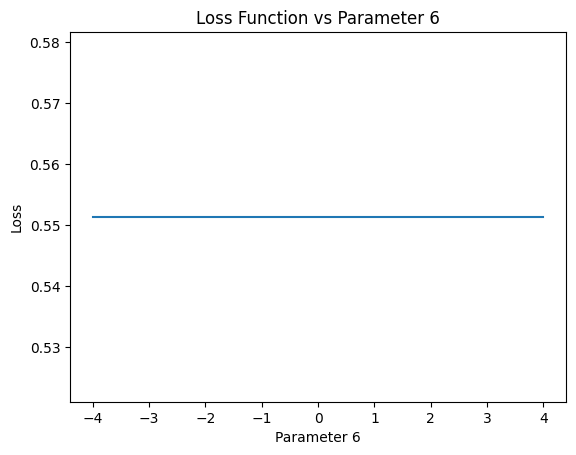

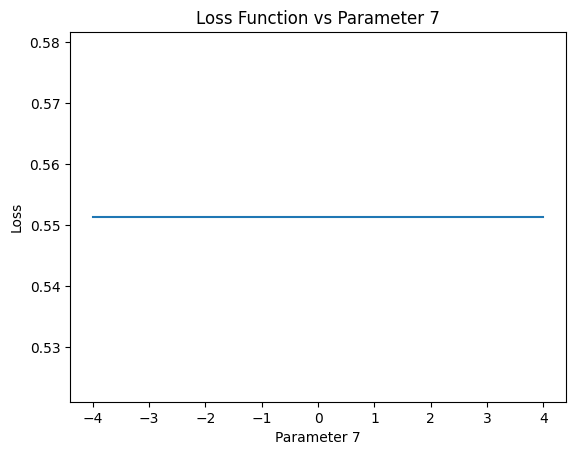

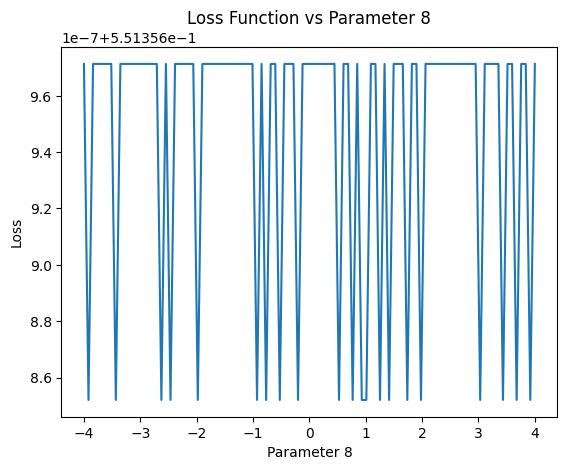

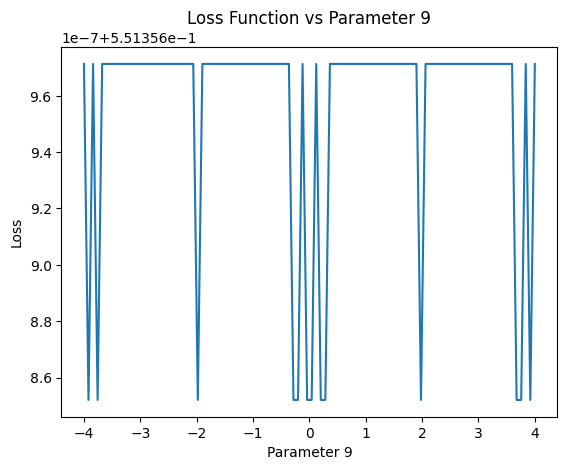

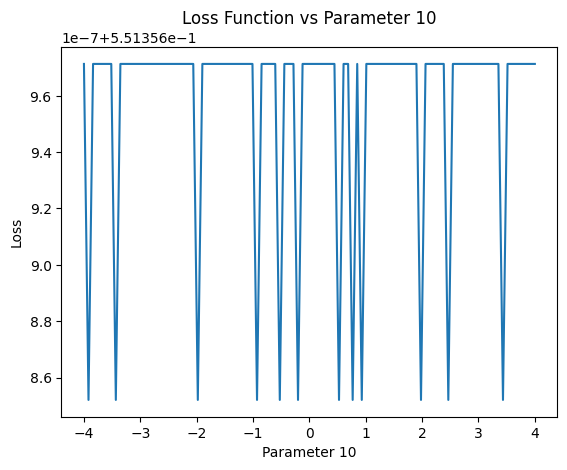

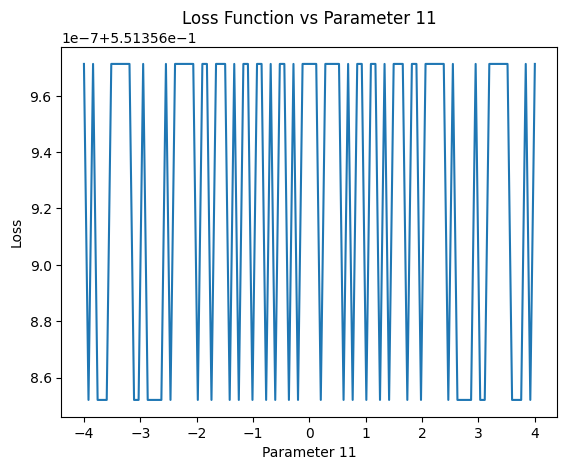

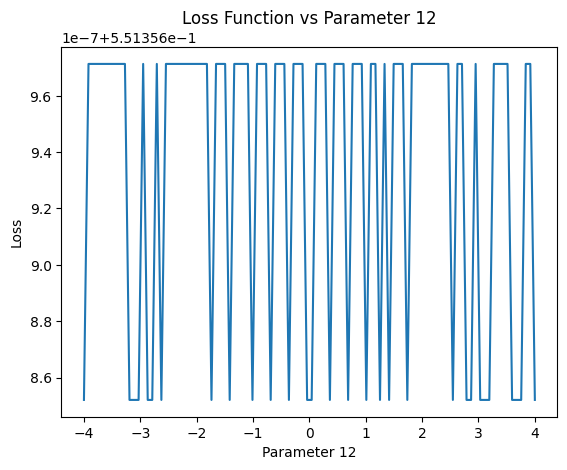

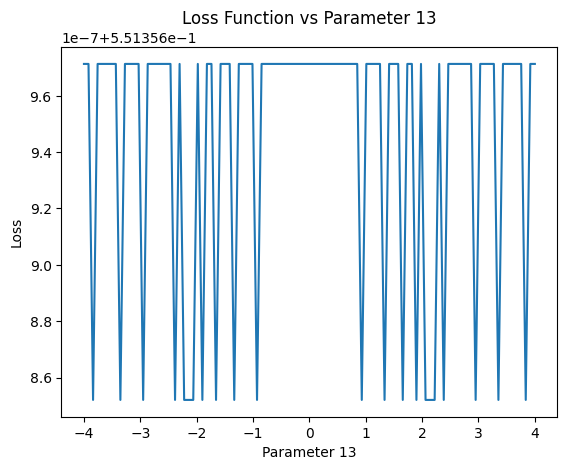

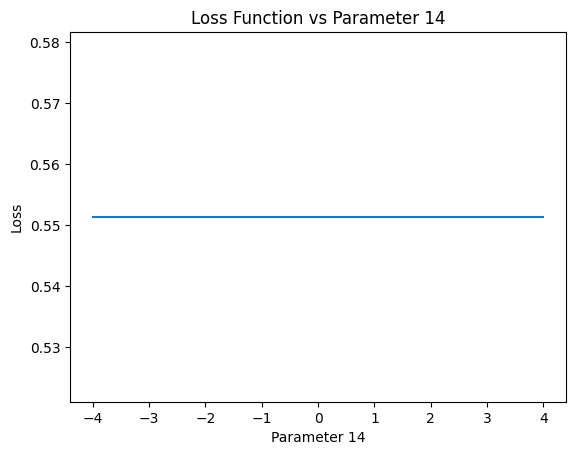

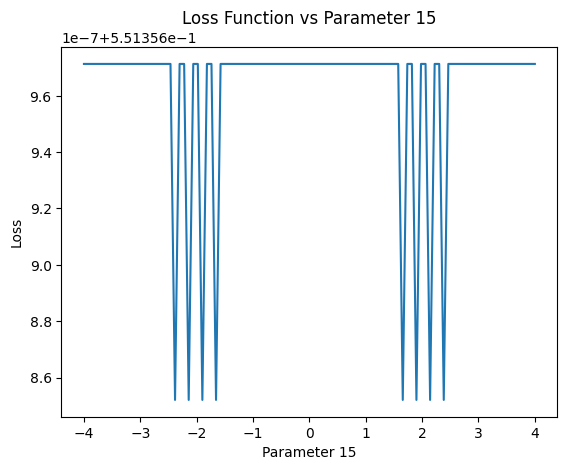

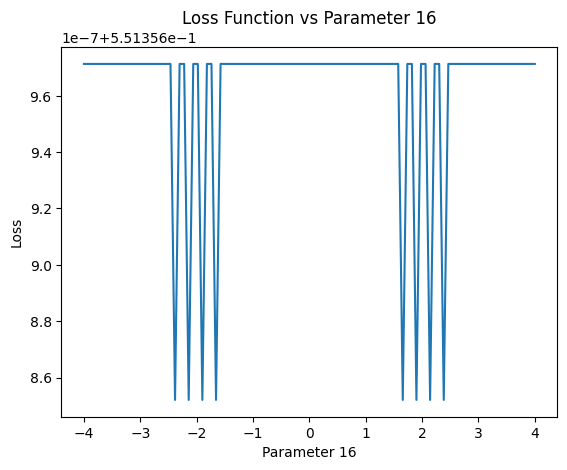

In [25]:


# Define the loss function over a range of values for each parameter
def plot_loss_over_params(model, x_train_tensor, y_train_tensor, param_index, param_range=np.linspace(-4, 4, 100)):
    # Clone the model parameters so we can manipulate them
    original_phis = model.phis.clone().detach()

    # Store the losses
    losses = []

    # Vary the selected parameter within the given range
    for param_value in param_range:
        # Set the selected parameter to the new value
        model.phis = torch.nn.Parameter(original_phis.clone())
        model.phis.data[param_index] = param_value  # Modify only the parameter at index `param_index`

        # Compute the loss
        model.eval()
        with torch.no_grad():
            outputs = model(x_train_tensor.to(device)).squeeze() # Move to device and squeeze
            loss = loss_fn(outputs, y_train_tensor.to(device)).item() # Move to device

        # Store the loss value
        losses.append(loss)

    # Plot the loss function for the selected parameter
    plt.plot(param_range, losses)
    plt.title(f"Loss Function vs Parameter {param_index + 1}")
    plt.xlabel(f"Parameter {param_index + 1}")
    plt.ylabel("Loss")
    plt.show()

# Example: plot the loss for the first parameter (index 0)
# Pass X_train_tensor and y_train_tensor as arguments
plot_loss_over_params(model, X_train_tensor, y_train_tensor, param_index=0)

# You can repeat this for other parameters (e.g., index 1, 2, etc.)
# Pass X_train_tensor and y_train_tensor as arguments to each call
for i in range(16):
    plot_loss_over_params(model, X_train_tensor, y_train_tensor, param_index=i)

In [26]:

unique, counts = np.unique(y_train, return_counts=True)
print(f"Training class distribution: {dict(zip(unique, counts))}")

unique, counts = np.unique(y_val_tensor.cpu().numpy(), return_counts=True) # Use y_val_tensor and move to CPU and convert to numpy
print(f"Validation class distribution: {dict(zip(unique, counts))}")

unique, counts = np.unique(y_test_tensor.cpu().numpy(), return_counts=True) # Use y_test_tensor and move to CPU and convert to numpy
print(f"Test class distribution: {dict(zip(unique, counts))}")

Training class distribution: {np.int64(0): np.int64(117), np.int64(1): np.int64(409)}
Validation class distribution: {np.float32(0.0): np.int64(17), np.float32(1.0): np.int64(89)}
Test class distribution: {np.float32(0.0): np.int64(33), np.float32(1.0): np.int64(99)}
